<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Магазин-одежды" data-toc-modified-id="Магазин-одежды-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Магазин одежды</a></span></li><li><span><a href="#Marketplace" data-toc-modified-id="Marketplace-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Marketplace</a></span></li><li><span><a href="#Магазин-подарков" data-toc-modified-id="Магазин-подарков-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Магазин подарков</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Подготовка-данных." data-toc-modified-id="Подготовка-данных.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных.</a></span></li><li><span><a href="#Модель-Catboost" data-toc-modified-id="Модель-Catboost-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель Catboost</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></div>

In [1]:
# Импорт библиотек

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
#from scipy import stats as st

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#from statsmodels.tsa.stattools import adfuller

#from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
import catboost
import time

from tqdm import tqdm
# from keras.models import Model
# from keras.layers import LSTM, Dense, Masking, Input, Concatenate, Reshape
# from keras.metrics import AUC
# from keras.utils import pad_sequences, plot_model, set_random_seed
# from keras.preprocessing.sequence import pad_sequences
# from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.regularizers import l1,l2
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from catboost import CatBoostClassifier, Pool, cv

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
#Даты выходных дней 22-23

is_holiday_22_23 = pd.to_datetime([
    "2022-01-01", "2022-01-02", "2022-01-03", "2022-01-04", "2022-01-05", "2022-01-06", "2022-01-08", "2022-01-07",
    "2022-02-23", "2022-03-08", "2022-05-01", "2022-05-02", "2022-05-09", "2022-06-12", "2022-06-13", "2022-11-04",
    "2023-01-01", "2023-01-02", "2023-01-03", "2023-01-04", "2023-01-05", "2023-01-06", "2023-01-08", "2023-01-07",
    "2023-02-23", "2023-03-08", "2023-05-01", "2023-05-09", "2023-06-12", "2023-11-04", "2023-02-24", "2023-05-08",
    "2023-11-06"
])

# Данные
Предоставлены данные о покупках из трёх разных интернет магазинов: магазин одежы, магазин подарков, маркетплейс. Необходимо предсказать, кто из клиентов сделает покупку в ближайшие 30 дней.

In [8]:
# Загрузка файла с данными
apparel_purchases = pd.read_csv('apparel-purchases.csv', parse_dates=['date'])# магазин одежды
gifts_purchases = pd.read_csv('gifts-purchases.csv', parse_dates=['date'])# магазин подарков
marketplace_purchases = pd.read_csv('marketplace-purchases.csv', parse_dates=['created_at'])# маркетплейс

In [9]:
apparel_purchases.head()

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


In [10]:
apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   client_id       133104 non-null  int64         
 1   quantity        133104 non-null  int64         
 2   price           133104 non-null  float64       
 3   date            133104 non-null  datetime64[ns]
 4   message_id      133104 non-null  object        
 5   recommended_by  133104 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.1+ MB


In [11]:
gifts_purchases.head()

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
3,1515915625803894158,1,11963.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
4,1515915625803894158,1,13107.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


In [12]:
gifts_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       811 non-null    int64         
 1   quantity        811 non-null    int64         
 2   price           811 non-null    float64       
 3   date            811 non-null    datetime64[ns]
 4   message_id      811 non-null    object        
 5   recommended_by  811 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 38.1+ KB


In [13]:
marketplace_purchases.head()

,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.0,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.0,1515915625441026424-1802-64634e24a2cb9,2023-05-17,2023-05-17 11:21:04
3,1515915625441118180,1,5598.0,1515915625441118180-1820-646c9444ebf39,2023-05-23,2023-05-23 19:02:53
4,1515915625441124500,1,77998.0,1515915625441124500-1825-646ed5cf4d5ed,2023-05-25,2023-05-25 07:46:52


In [14]:
marketplace_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   48182 non-null  int64         
 1   quantity    48182 non-null  int64         
 2   price       48182 non-null  float64       
 3   message_id  48182 non-null  object        
 4   created_at  48182 non-null  datetime64[ns]
 5   date        48182 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 2.2+ MB


Пропусков в данных нет. Во всех данных содержатся столбцы:
- client_id - индивидуальный номер клиента;
- quantity - количество товара;
- price - цена товара;
- date - дата (+время) покупки

Так же встречаются столбцы:
- message_id - ID отправленного сообщения
- created_at - дата создания заказа
- recommended_by - рекоммендация


План:

- изучить предоставленные данные
- создать полезные признаки для обучения модели
- создать целевой признак
- предложить и обосновать метрику
- обучить модель
- протестировать и проверить

## Анализ данных

Напишем функцию для визуализации функция количества и объема продаж, а так же числа покупателей

In [15]:
def plot_sales_statistics(data):
    # Преобразование столбца 'date' в тип datetime
    data['date'] = pd.to_datetime(data['date'])

    # Извлечение месяца из столбца 'date'
    data['month'] = data['date'].dt.to_period('M')
    
    # Группировка данных по дате и подсчёт количества проданного товара
    quantity_goods_per_day = data.groupby('date')['quantity'].sum().reset_index(name='quantity')

    # Группировка данных по месяцам и подсчет числа продаж
    sales_per_month = data.groupby('month').size().reset_index(name='count')

    # Группировка данных по месяцам и вычисление суммы цен продаж
    total_sales_per_month = data.groupby('month')['price'].sum().reset_index(name='total_price')
    
    plt.style.use('default')
    plt.rcParams.update({"grid.linewidth":0.3, "grid.alpha":0.5})
    # Создание общего рисунка и подграфиков
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 20))
    
    # Построим график распределения количества проданного товаа от даты
    sns.lineplot(x = 'date', y = 'quantity', data = quantity_goods_per_day, color='blue', ax=ax1)
    ax1.set(xlabel='Дата', ylabel='Количество товара', title='Продажи в магазине')
    ax1.grid()

    # Построение графика числа продаж по месяцам
    sns.barplot(x='month', y='count', data=sales_per_month, color='skyblue', ax=ax2)
    ax2.set_title('Количество  продаж за месяц')
    ax2.set_xticklabels(sales_per_month['month'], rotation=45)
    ax2.set_xlabel('Месяц')
    ax2.set_ylabel('Количество продаж')

    # Построение графика суммарной стоимости продаж по месяцам
    sns.barplot(x='month', y='total_price', data=total_sales_per_month, color='salmon', ax=ax3)
    ax3.set_title('Ежемесячный объем продаж')
    ax3.set_xticklabels(total_sales_per_month['month'], rotation=45)
    ax3.set_xlabel('Месяц')
    ax3.set_ylabel('Сумма продаж за месяц')
    
    data['date'] = pd.to_datetime(data['date'])
    data['month'] = data['date'].dt.to_period('M')

    # Найдем новых клиентов для каждого месяца
    first_purchase_per_customer = data.groupby('client_id')['month'].min().reset_index()
    new_customers_per_month = first_purchase_per_customer.groupby('month').size().reset_index(name='new_customers')
    #new_customers_per_month = data.drop_duplicates('client_id').groupby('month').size().reset_index(name='new_customers')

    # Найдем общее количество клиентов для каждого месяца
    total_customers_per_month = data.groupby('month')['client_id'].nunique().reset_index(name='total_customers')

    # Объединим данные по новым и общим клиентам
    customers_data = pd.merge(total_customers_per_month, new_customers_per_month, on='month')
    
   

    sns.set_color_codes("pastel")
    sns.barplot(x='month', y='new_customers', data=customers_data, label='Новые покупатели', color='r', alpha=0.7, ax=ax4)
    
    sns.set_color_codes("muted")
    sns.barplot(x='month', y='total_customers', data=customers_data, label='Всего покупателей', color='b', alpha=0.5, ax=ax4)

    
    ax4.set_title('Уникальные покупатели и новые покупатели')
    ax4.set_xticklabels(total_sales_per_month['month'], rotation=45)
    ax4.set_xlabel('Месяц')
    ax4.set_ylabel('Количество покупателей')
    ax4.legend(loc='upper left', frameon=False)


    plt.tight_layout()
    plt.subplots_adjust(wspace=1)  # Увеличиваем расстояние между подграфиками
    plt.show()

Напишем функцию построения графиков зависимости количества и суммы продаж по длям недели

In [16]:
def plot_sales_weekdays(data):
    # Добавление столбца с днем недели (0 - понедельник, 1 - вторник, и так далее)
    data['day_of_week'] = data['date'].dt.dayofweek
#     # Добавление столбца с днем недели (0 - понедельник, 1 - вторник, и так далее)
#     data['day_of_week'] = data['date'].dt.dayofweek
    # Группировка данных по дню недели
    day_of_week_data = data.groupby('day_of_week').agg({
        'quantity': 'sum',
        'price': 'sum',
      #  'orders_per_week': 'sum' 
    }).reset_index()

# Маппинг для преобразования числовых значений дня недели в текстовый формат
    day_mapping = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}
    day_of_week_data['day_of_week'] = day_of_week_data['day_of_week'].map(day_mapping)
    
    
    plt.style.use('default')
    plt.rcParams.update({"grid.linewidth":0.3, "grid.alpha":0.5})
    # Создание общего рисунка и подграфиков
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
    
    sns.barplot(x='day_of_week', y='quantity', data=day_of_week_data, palette='viridis', ax=ax1)
    ax1.set_title('Изменение Количества Товара в Заказах по Дням Недели')
    ax1.set_xlabel('День Недели')
    ax1.set_ylabel('Общее Количество товара в Заказах')
    
    sns.barplot(x='day_of_week', y='price', data=day_of_week_data, palette='viridis',ax=ax2)
    ax2.set_title('Изменение Суммы Заказов по Дням Недели')
    ax2.set_xlabel('День Недели')
    ax2.set_ylabel('Общая Сумма Заказов')
 
    plt.show()  

Напишем функцию для построения диаграммы рассеивания: количество товаров в заказе - цена

In [17]:
def scatter_plot(data):
    # количество уникальных клиентов
    print('Количество уникальных клиентов:', data['client_id'].nunique())
    # количество товаров
    print('Количество уникальных товаров в заказах:', data['quantity'].unique())
    fig, ax = plt.subplots(figsize=(15,8))
    ax.scatter(data['quantity'], data['price'],\
            edgecolors="black")
    ax.set(xlabel='Количество единиц товара', ylabel='цена',
       title='Диаграмма рассеивания количества товаров и цены')
    ax.grid()
    plt.show
    None

Напишеи функцию расчета суммы покупок для каждого клиента]

In [18]:
def client_spending(data, N):
    # Упорядочиваем датасет по дате и клиенту
    data_sorted = data.sort_values(by=['date', 'client_id'])

    # Группируем по клиенту и дате, суммируем количество и сумму цен
    data_total = data_sorted.groupby(['date', 'client_id']).agg({
    'quantity': 'sum',
    'price': 'sum'
    }).reset_index()

    data_total = data_total.rename(columns={'quantity': 'quantity_total', 'price': 'price_total'})

    # Убеждаемся, что новый датафрейм создан корректно
    display(data_total.head())
    # Расчет суммы покупок для каждого клиента
    client_total_spending = data_total.groupby('client_id')['price_total'].sum().sort_values(ascending=False)
    # Вывод рейтинга клиентов
    print("Рейтинг клиентов по общей сумме покупок:")
    display(client_total_spending)

    # Количество клиентов, сделавших покупки на 20 тысяч и выше
    high_spending_clients = client_total_spending[client_total_spending >= N]
    low_spending_clients = client_total_spending[client_total_spending < N]

    # Вывод количества клиентов на 20 тысяч и выше
    print(f'Количество клиентов с покупками на {N} и выше:', len(high_spending_clients))
    print(f'Количество клиентов с покупками на менее чем {N}:', len(low_spending_clients))
    
    # визуализируем полученные данные
    plt.bar([f'{N} и выше', f'Менее {N}'], [len(high_spending_clients), len(low_spending_clients)])

    # Добавление подписей и заголовка
    plt.xlabel('Сумма покупок')
    plt.ylabel('Количество клиентов')
    plt.title('Количество клиентов с разными суммами покупок')

    # Отображение графика
    plt.show()
    

### Магазин одежды

In [21]:
print(apparel_purchases.shape)
print('Дата первой покупки:', min(apparel_purchases['date']))
print('Дата последней покупки:', max(apparel_purchases['date']))
apparel_purchases.head(5)

(133104, 6)
Дата первой покупки: 2022-10-26 00:00:00
Дата последней покупки: 2023-10-26 00:00:00


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


Данные предоставлены за год.

**Построения диаграммы рассеивания: количество товаров в заказе - цена**

Количество уникальных клиентов: 28891
Количество уникальных товаров в заказах: [ 1  2  3  6  4 20 15  5 30 18  9  8]


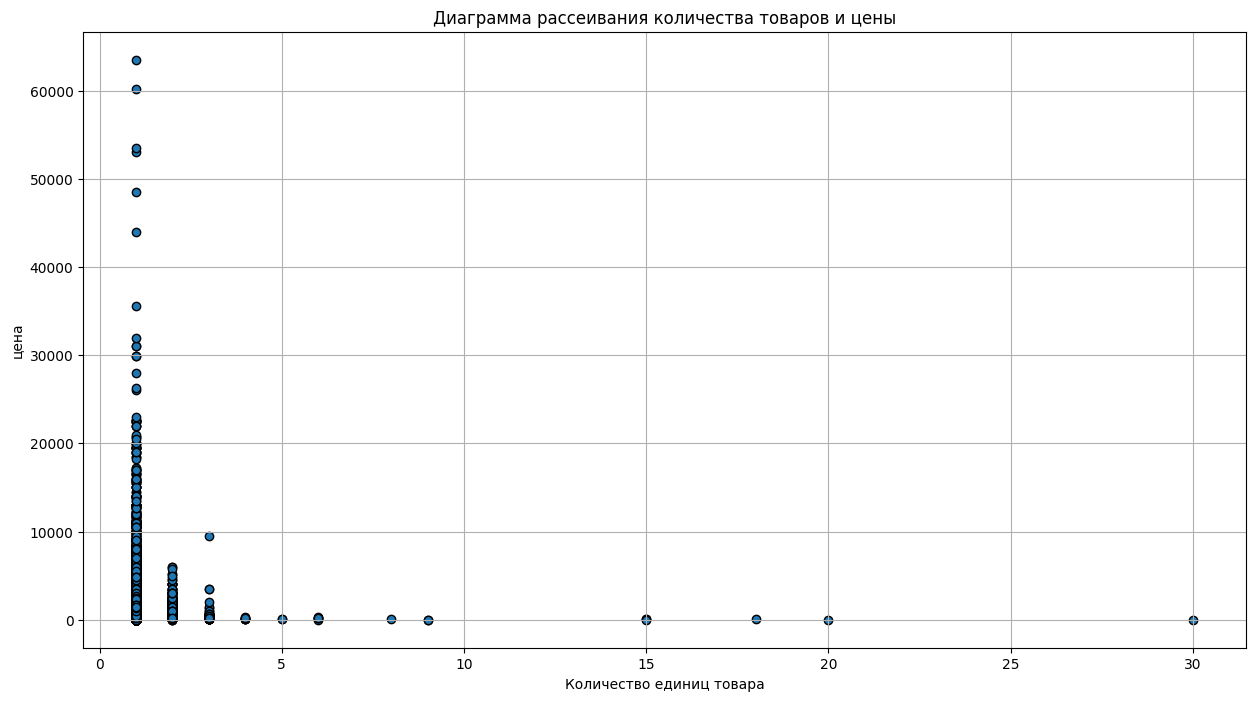

In [22]:
scatter_plot(apparel_purchases)

Все дорогие покупки единичные.

**Проанализируем как меняется покупательское поведение в зависимости от даты.**

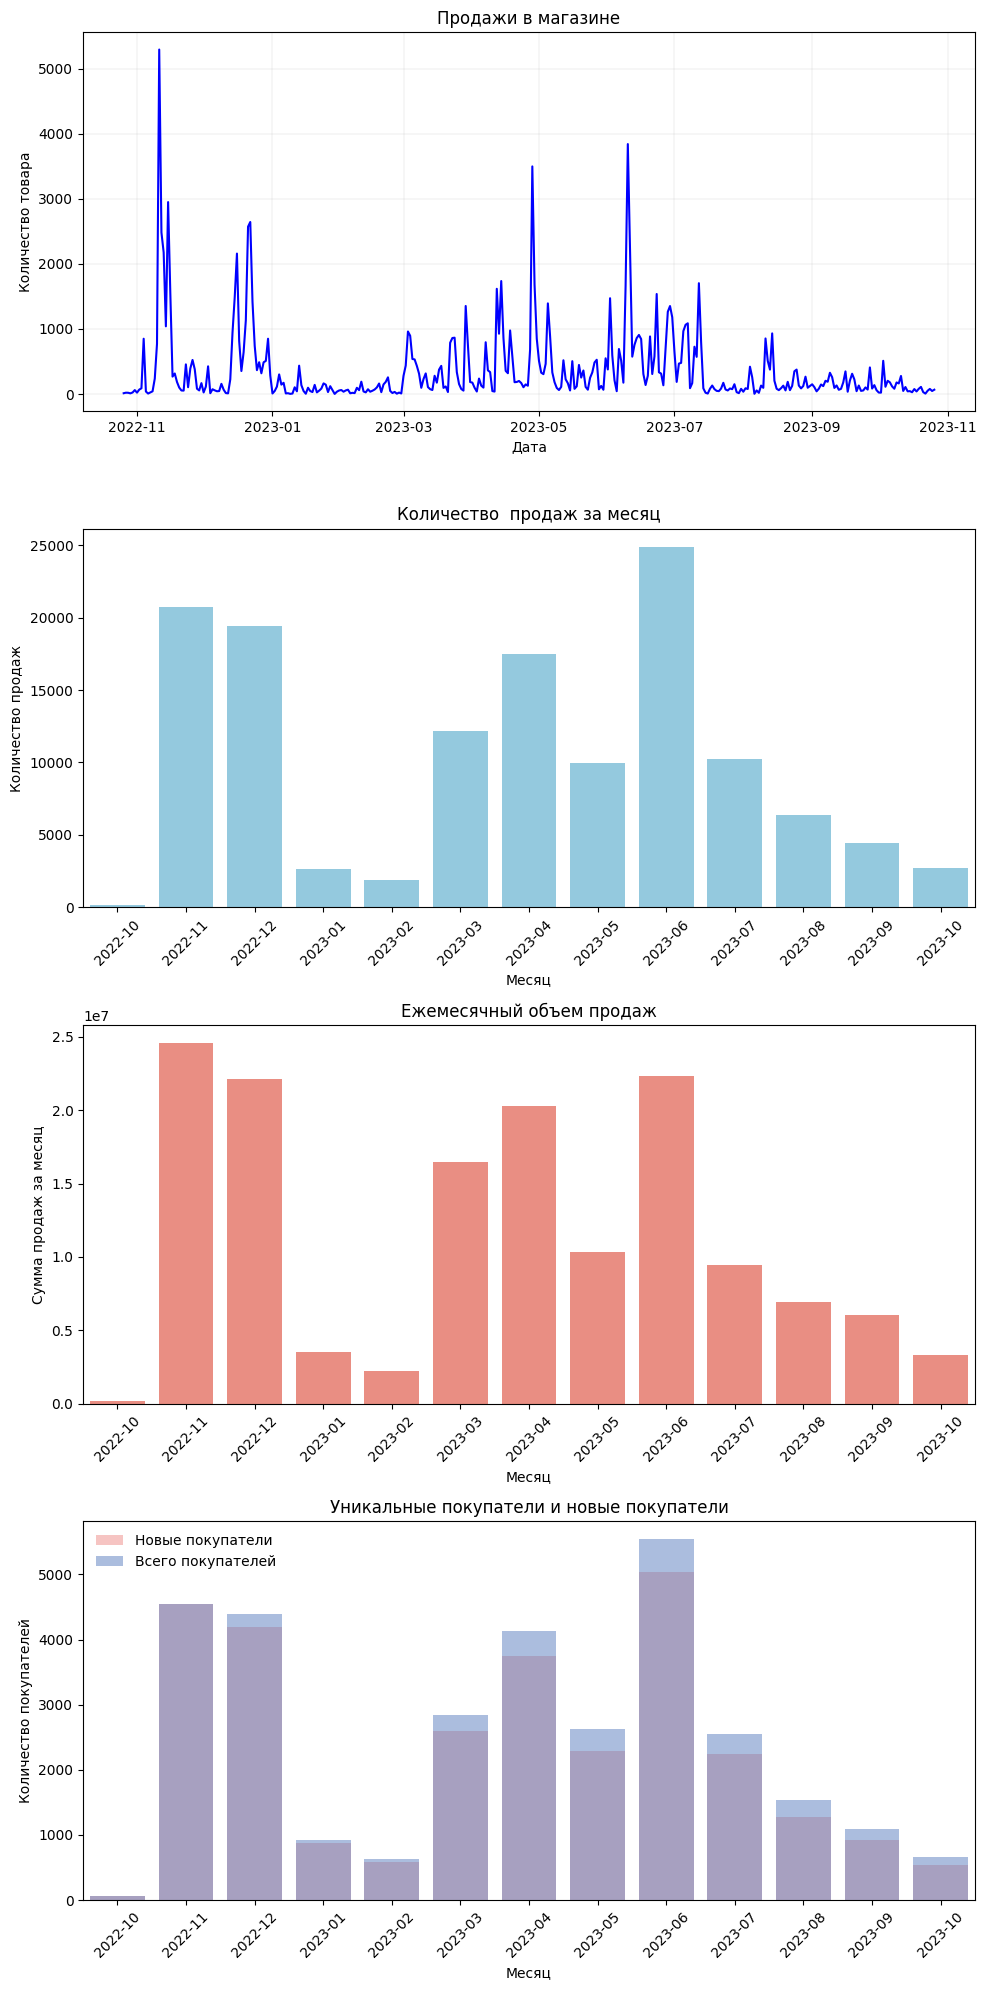

In [23]:
plot_sales_statistics(apparel_purchases)

Явно наблюдаются всплески в активности покупателей: ноябрь, декабрь, апрель, июнь.
Количество новых покупателей в магазине гораздо больше, чем сделавших повторные покупки. 


Это может указывать на необходимость усиления усилий по удержанию клиентов и повышению лояльности среди тех, кто уже совершил покупки. Работа с программами лояльности, персонализированными предложениями или скидками для постоянных клиентов может быть эффективным способом увеличить долю постоянных клиентов в общей клиентской базе. Также стоит дополнительно изучить причины, по которым новые клиенты не становятся постоянными, чтобы оптимизировать маркетинговые стратегии и улучшить клиентский опыт.

**Проанализировать как меняется покупательское поведение в разные дни недели и в выходные.** Это может помочь определить оптимальные дни для проведения маркетинговых акций.

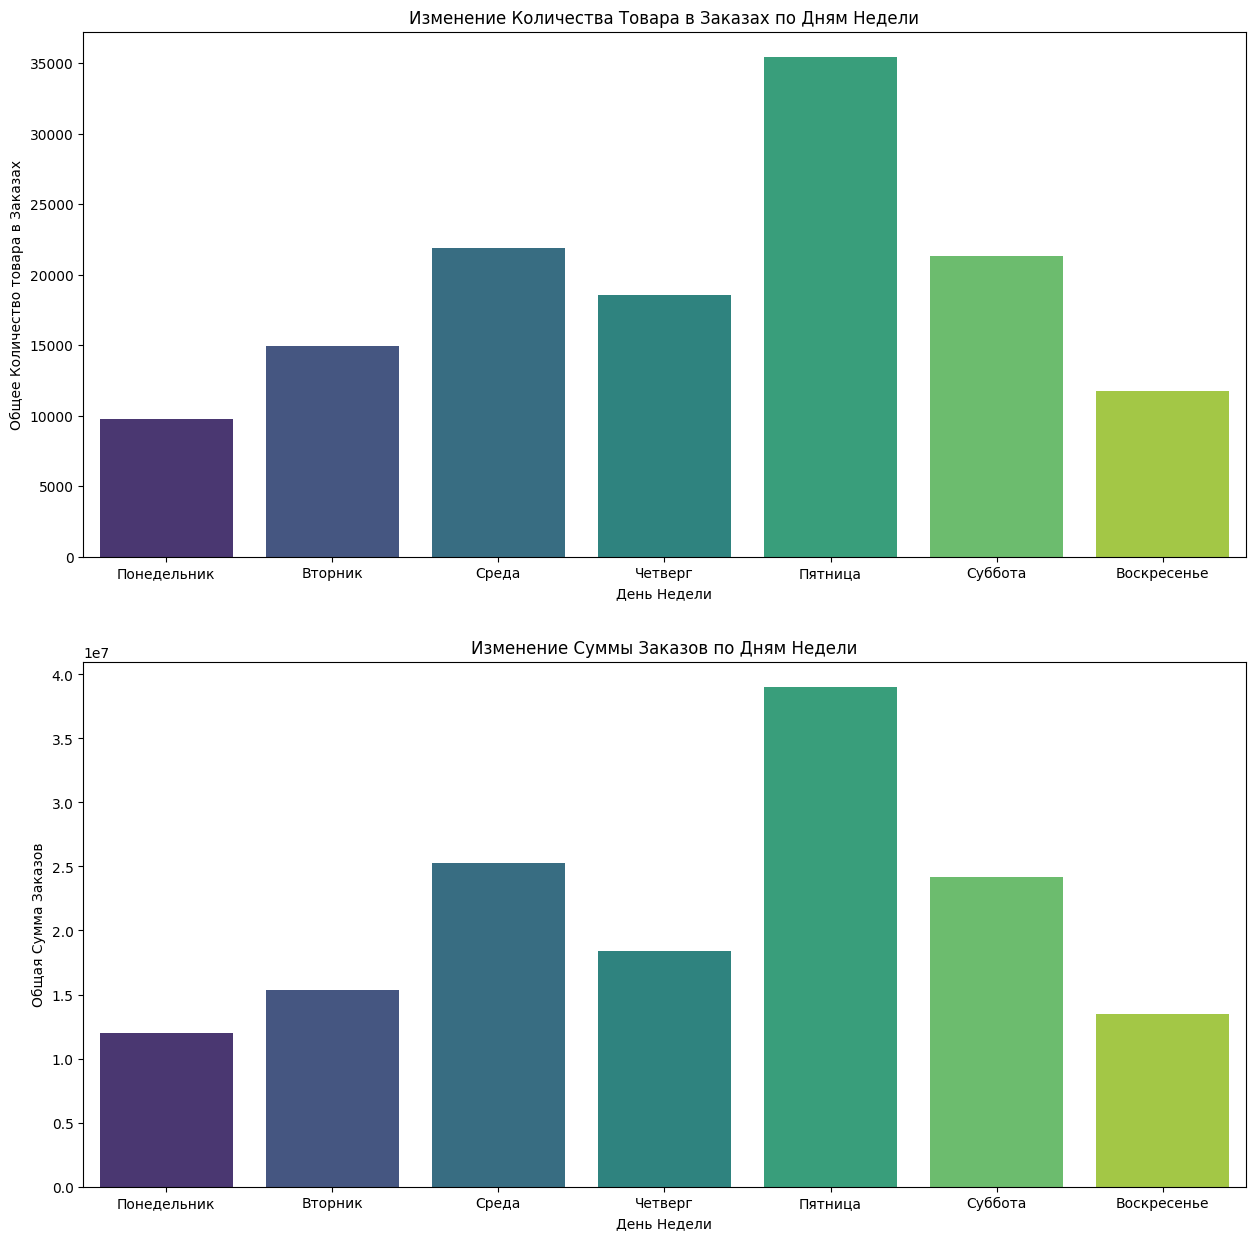

In [24]:
plot_sales_weekdays(apparel_purchases)

Анализ распределения количества товаров и распределения сумм заказов по дням недели выявил следующие тренды:

- Пятница является лидером по количеству товаров в заказах.
- Среда и суббота демонстрируют схожие показатели.
- Четверг следует за средой и субботой.
- Вторник и воскресенье имеют более умеренные значения.
- Понедельник демонстрирует наименьшее количество товаров в заказах.

Эти данные могут подсказывать о паттернах в покупательском поведении, что может быть полезно для определения оптимальных дней для проведения маркетинговых акций. Например, пятница, с ее высоким показателем, может быть привлекательным днем для акций или специальных предложений, в то время как в понедельник можно сосредоточить усилия на стимулировании покупок.

**Рассчитаем сколько каждый клиент потратил в магазине**

,date,client_id,quantity_total,price_total
0,2022-10-26,1515915625468222486,2,7998.0
1,2022-10-26,1515915625489888679,3,2213.0
2,2022-10-26,1515915625500418210,1,1859.0
3,2022-10-26,1515915625558655965,3,3298.0
4,2022-10-26,1515915625581772632,1,2100.0


Рейтинг клиентов по общей сумме покупок:


client_id
1515915625853312319    228172.0
1515915625776653984    164218.0
1515915625500232103    162103.0
1515915625959777467    145497.0
1515915625580548703    138558.0
                         ...   
1515915625815787353         1.0
1515915625488345285         1.0
1515915625550303061         1.0
1515915625558835949         1.0
1515915625590643562         1.0
Name: price_total, Length: 28891, dtype: float64

Количество клиентов с покупками на 30000 и выше: 334
Количество клиентов с покупками на менее чем 30000: 28557


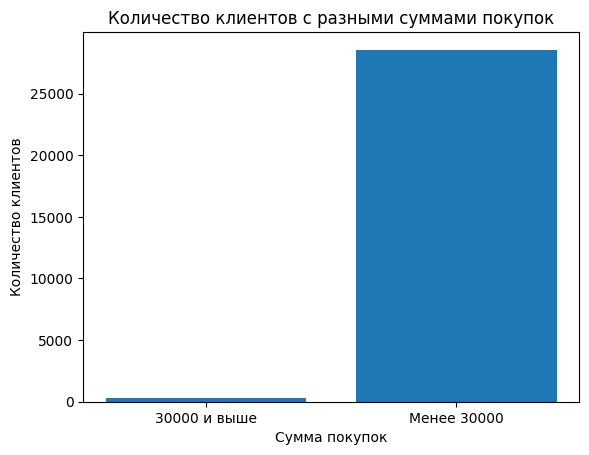

In [25]:
client_spending(apparel_purchases, 30000)

Из полученных данных можно сделать вывод, что большую часть дохода приносит небольшое количество клиентов. Этих клиентов можно выделить в VIP и предоставит им особую программу лояльности.

### Marketplace

In [26]:
print(marketplace_purchases.shape)
print('Дата первой покупки:', min(marketplace_purchases['date']))
print('Дата последней покупки:', max(marketplace_purchases['date']))

marketplace_purchases.head(5)

(48182, 6)
Дата первой покупки: 2022-10-26 08:35:46
Дата последней покупки: 2023-10-26 13:34:11


,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.0,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.0,1515915625441026424-1802-64634e24a2cb9,2023-05-17,2023-05-17 11:21:04
3,1515915625441118180,1,5598.0,1515915625441118180-1820-646c9444ebf39,2023-05-23,2023-05-23 19:02:53
4,1515915625441124500,1,77998.0,1515915625441124500-1825-646ed5cf4d5ed,2023-05-25,2023-05-25 07:46:52


Данные предоставлены за год.

Количество уникальных клиентов: 17787
Количество уникальных товаров в заказах: [ 1  2  3  4  5 27  6  8  7 10  9 23 50 20 30]


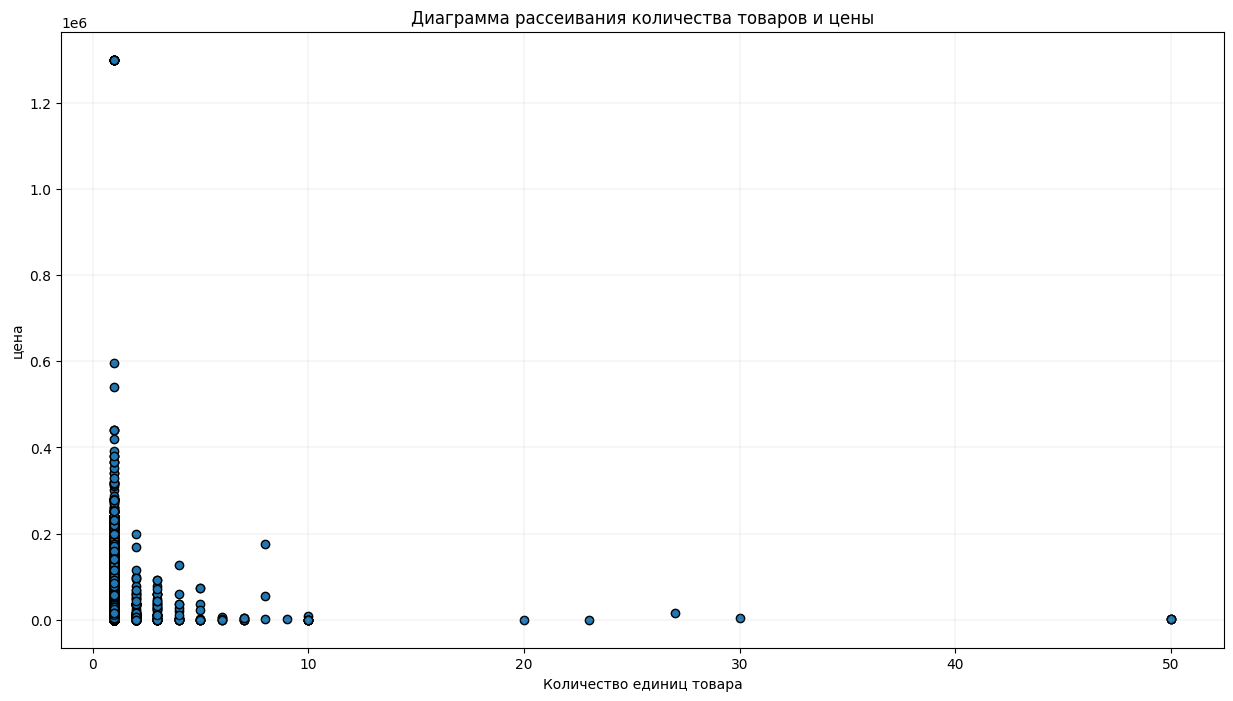

In [27]:
scatter_plot(marketplace_purchases)

Все дорогие покупки единичны

In [28]:
# количество уникальных клиентов
print('Количество уникальных клиентов:', marketplace_purchases['client_id'].nunique())

Количество уникальных клиентов: 17787


**Проанализируем как меняется покупательское поведение в зависимости от даты.**

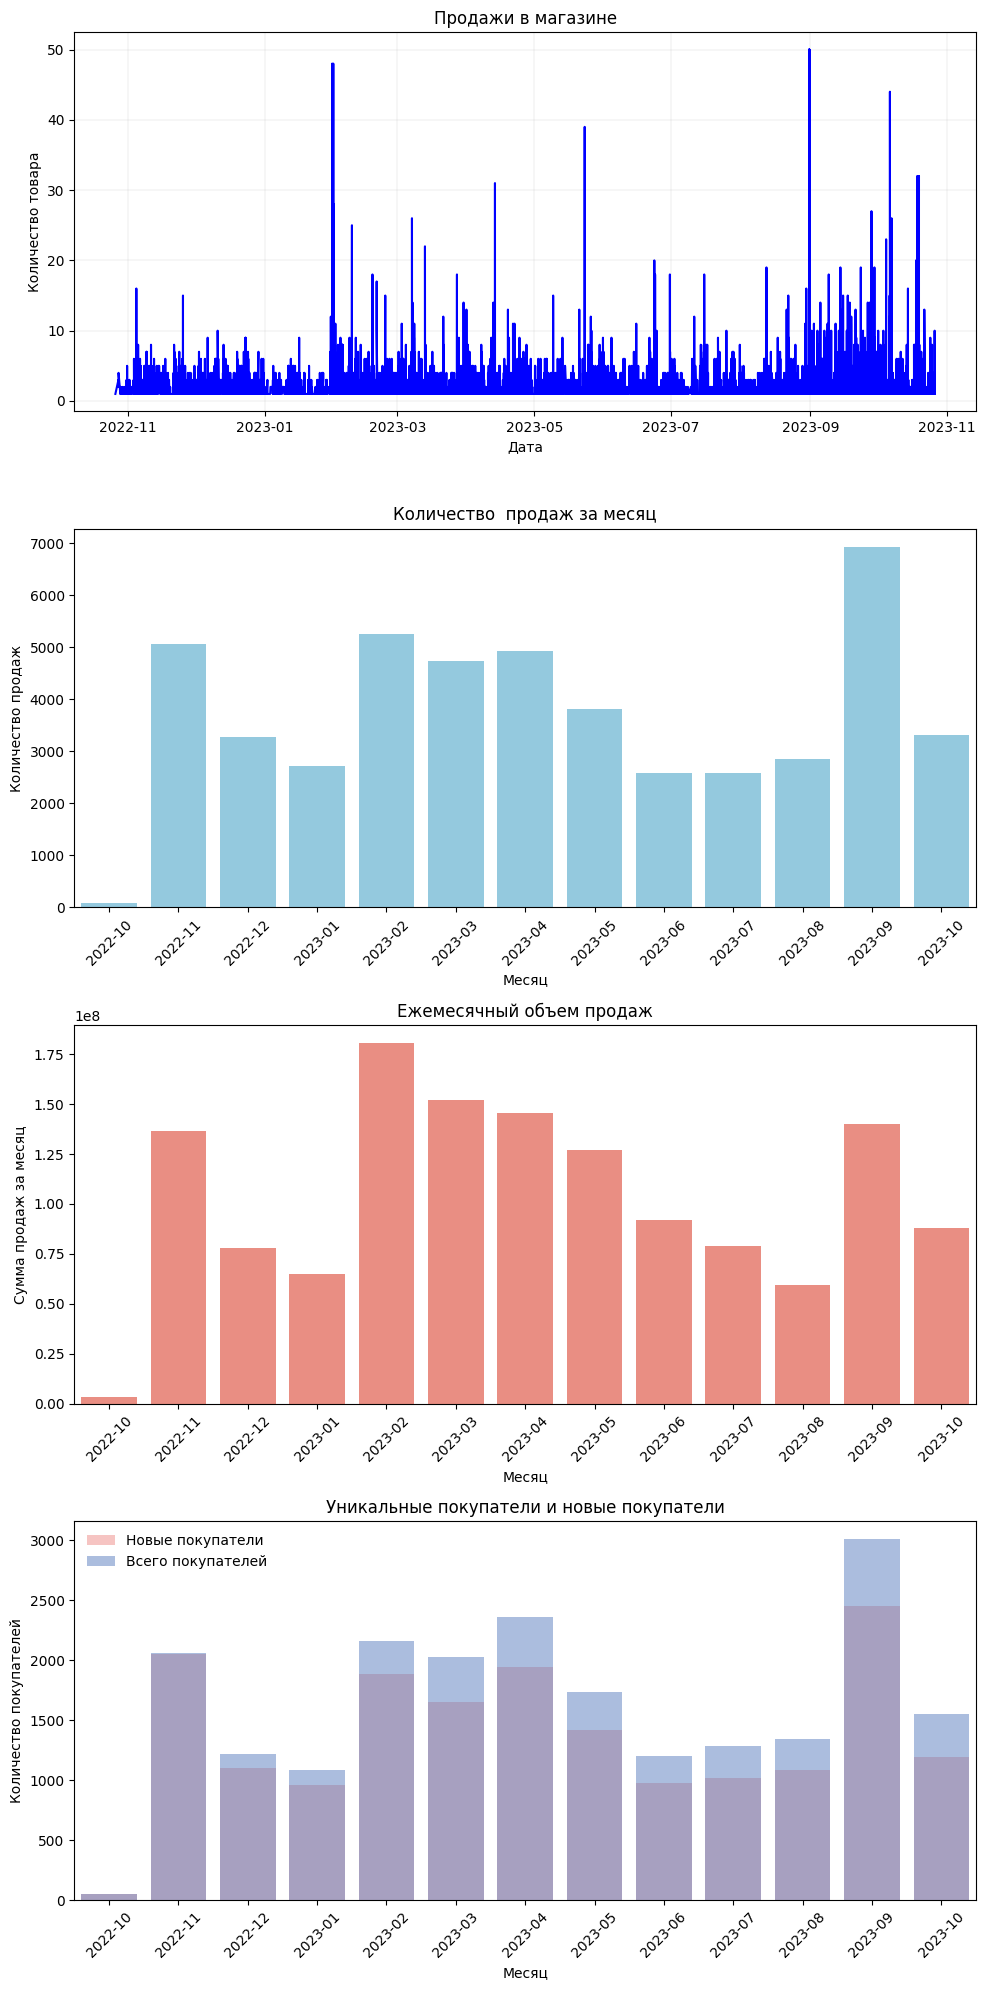

In [29]:
plot_sales_statistics(marketplace_purchases)

Явно наблюдаются всплески в активности покупателей: ноябрь,  февраль, сентябрь. Количество новых покупателей в магазине гораздо больше, чем сделавших повторные покупки.

Это может указывать на необходимость усиления усилий по удержанию клиентов и повышению лояльности среди тех, кто уже совершил покупки. Работа с программами лояльности, персонализированными предложениями или скидками для постоянных клиентов может быть эффективным способом увеличить долю постоянных клиентов в общей клиентской базе. Также стоит дополнительно изучить причины, по которым новые клиенты не становятся постоянными, чтобы оптимизировать маркетинговые стратегии и улучшить клиентский опыт.



**Проанализировать как меняется покупательское поведение в разные дни недели и в выходные.** Это может помочь определить оптимальные дни для проведения маркетинговых акций.

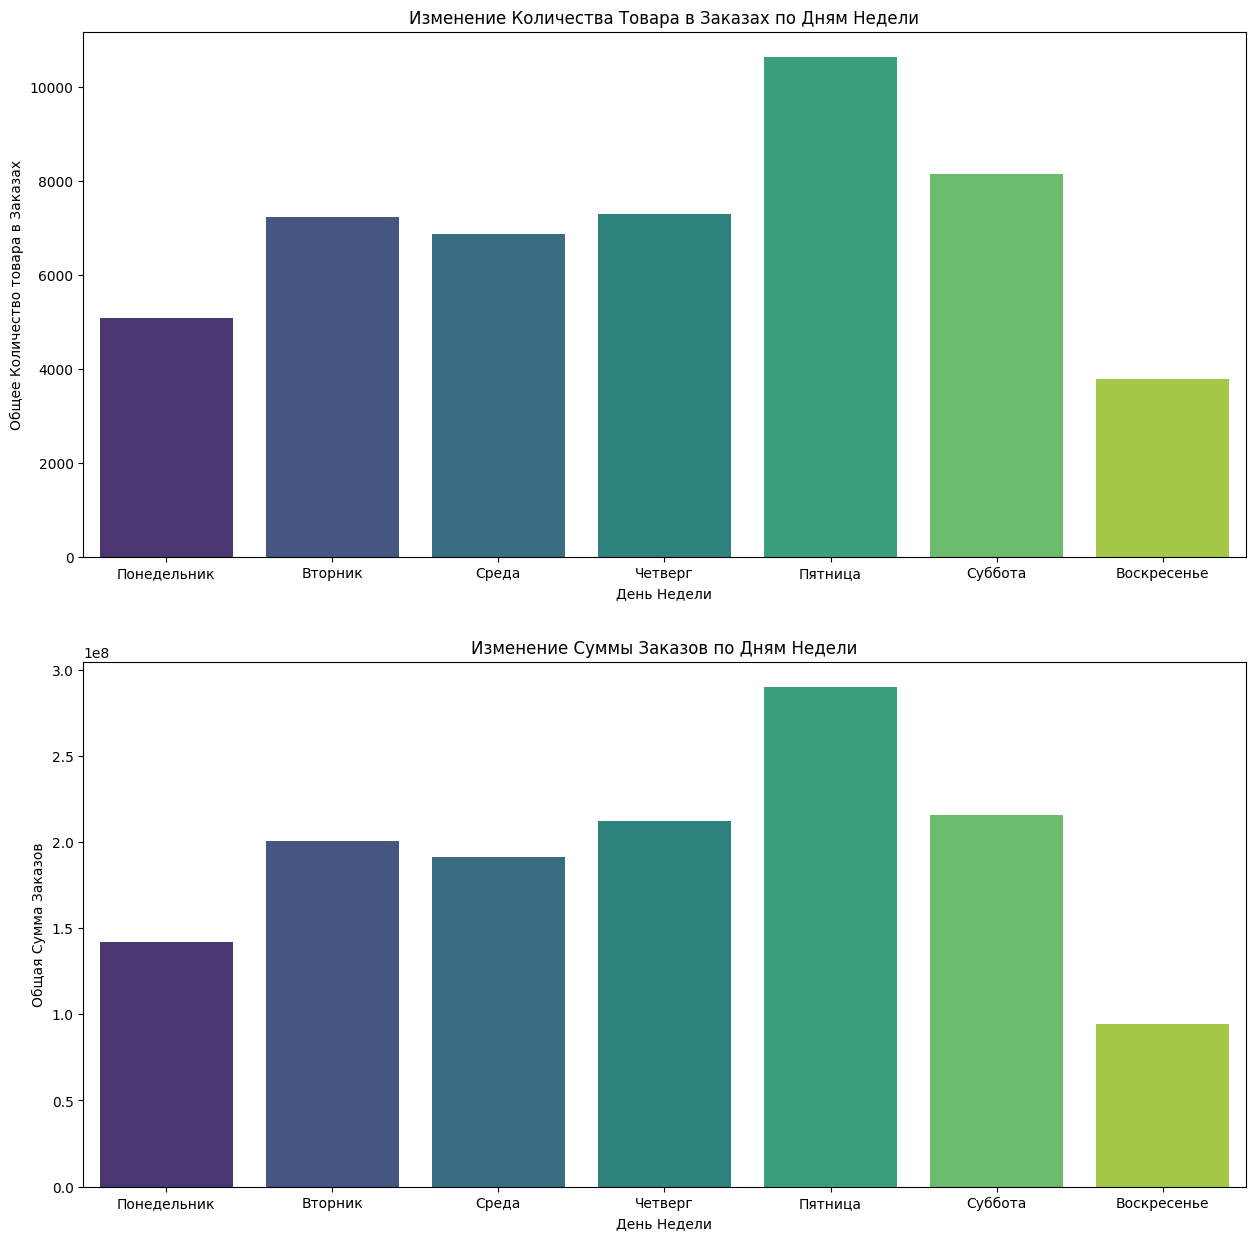

In [30]:
plot_sales_weekdays(marketplace_purchases)

Анализ распределения количества товаров и распределения сумм заказов по дням недели выявил следующие тренды:

- Пятница является лидером по количеству товаров в заказах.
- Суббота и четверг демонстрируют схожие показатели.
- Вторник и среда имеют более умеренные значения.
- Понедельник имеет более умеренное значение.
- Воскресенье демонстрирует наименьшее количество товаров в заказах.

Эти данные могут подсказывать о паттернах в покупательском поведении, что может быть полезно для определения оптимальных дней для проведения маркетинговых акций. Например, пятница, с ее высоким показателем, может быть привлекательным днем для акций или специальных предложений, в то время как в понедельник можно сосредоточить усилия на стимулировании покупок.

**Рассчитаем сколько каждый клиент потратил в магазине**

,date,client_id,quantity_total,price_total
0,2022-10-26 08:35:46,1515915625562386426,1,10598.0
1,2022-10-27 17:12:22,1515915625519806198,3,79596.0
2,2022-10-27 17:19:44,1515915625519806198,2,135396.0
3,2022-10-27 18:15:59,1515915625519806198,4,246993.0
4,2022-10-28 13:46:57,1515915625560501241,1,973.0


Рейтинг клиентов по общей сумме покупок:


client_id
1515915625557752721    17300385.0
1515915625518981759    15599976.0
1515915625556206544     6977093.0
1515915625546393273     6631350.0
1515915625548079160     5661928.0
                          ...    
1515915625498203778           2.0
1515915625517490789           2.0
1515915625519353191           2.0
1515915625533857143           2.0
1515915625520674208           0.0
Name: price_total, Length: 17787, dtype: float64

Количество клиентов с покупками на 100000 и выше: 3972
Количество клиентов с покупками на менее чем 100000: 13815


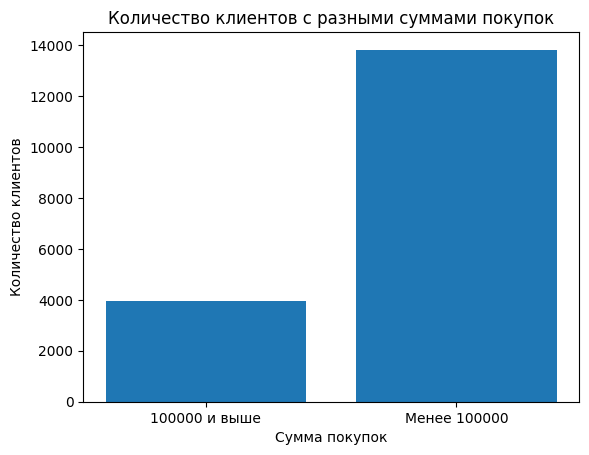

In [31]:
client_spending(marketplace_purchases, 100000)

Из полученных данных можно сделать вывод, что большую часть дохода приносит небольшое количество клиентов. Этих клиентов можно выделить в VIP и предоставит им особую программу лояльности.

### Магазин подарков

In [32]:
print(gifts_purchases.shape)
print('Дата первой покупки:', min(gifts_purchases['date']))
print('Дата последней покупки:', max(gifts_purchases['date']))
gifts_purchases.head(5)

(811, 6)
Дата первой покупки: 2022-10-26 00:00:00
Дата последней покупки: 2023-10-24 00:00:00


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
3,1515915625803894158,1,11963.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
4,1515915625803894158,1,13107.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


Количество уникальных клиентов: 326
Количество уникальных товаров в заказах: [1 2]


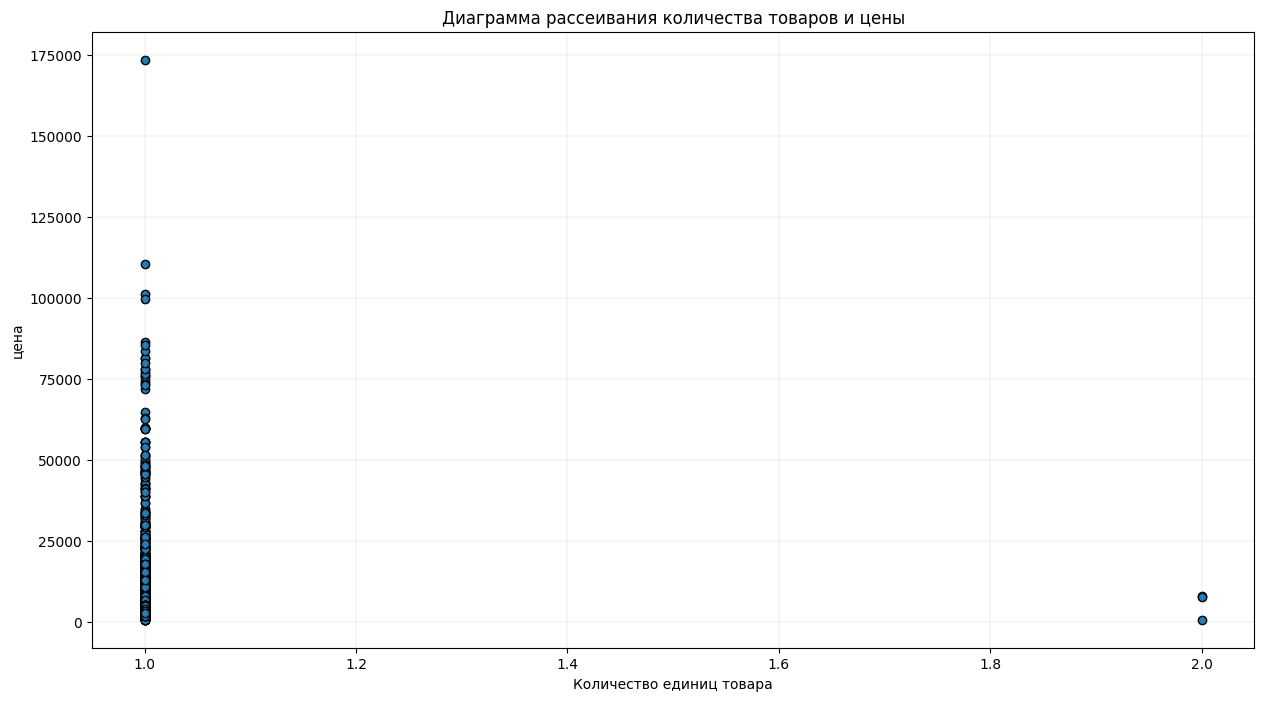

In [33]:
scatter_plot(gifts_purchases)

Все покупки единичны!

**Проанализируем как меняется покупательское поведение в зависимости от даты.**

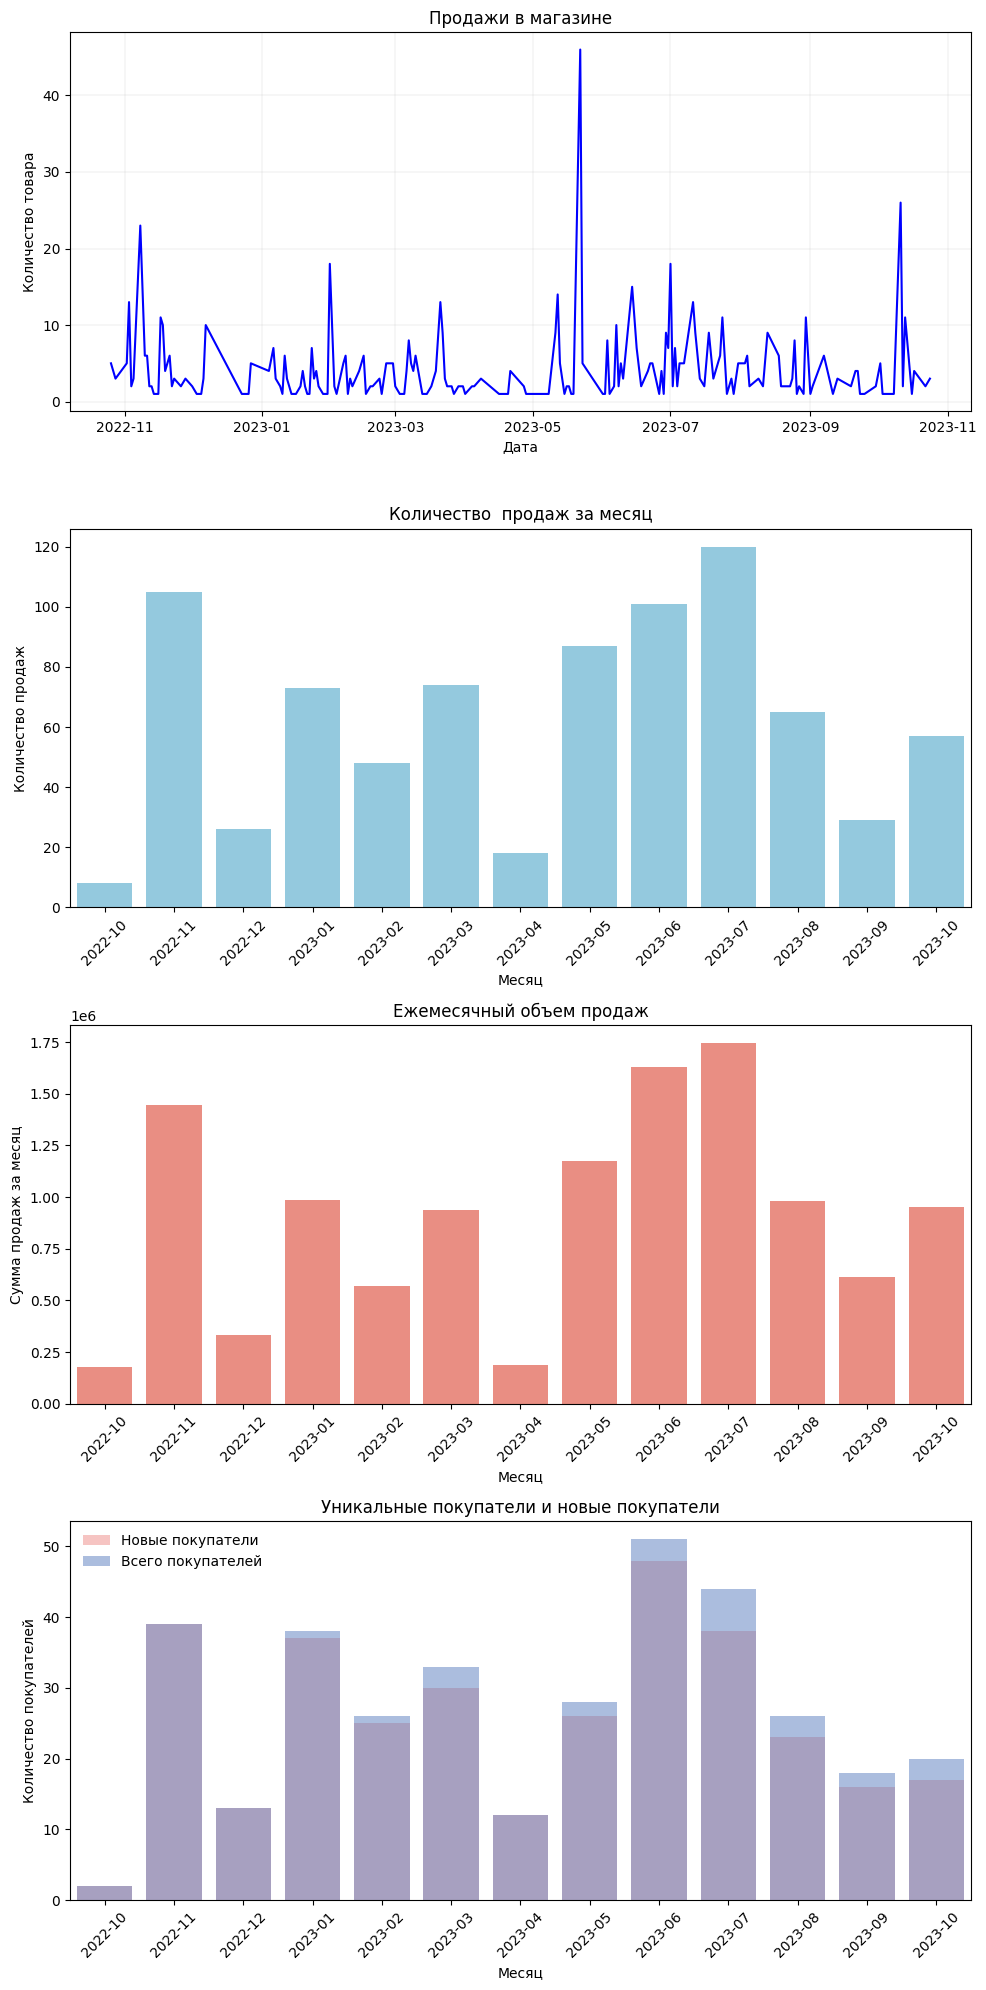

In [34]:
plot_sales_statistics(gifts_purchases)

Явно наблюдаются всплески в активности покупателей: ноябрь, январь, март, июль. Количество новых покупателей в магазине гораздо больше, чем сделавших повторные покупки.

Это может указывать на необходимость усиления усилий по удержанию клиентов и повышению лояльности среди тех, кто уже совершил покупки. Работа с программами лояльности, персонализированными предложениями или скидками для постоянных клиентов может быть эффективным способом увеличить долю постоянных клиентов в общей клиентской базе. Также стоит дополнительно изучить причины, по которым новые клиенты не становятся постоянными, чтобы оптимизировать маркетинговые стратегии и улучшить клиентский опыт.

**Проанализировать как меняется покупательское поведение в разные дни недели и в выходные.**
Это может помочь определить оптимальные дни для проведения маркетинговых акций.

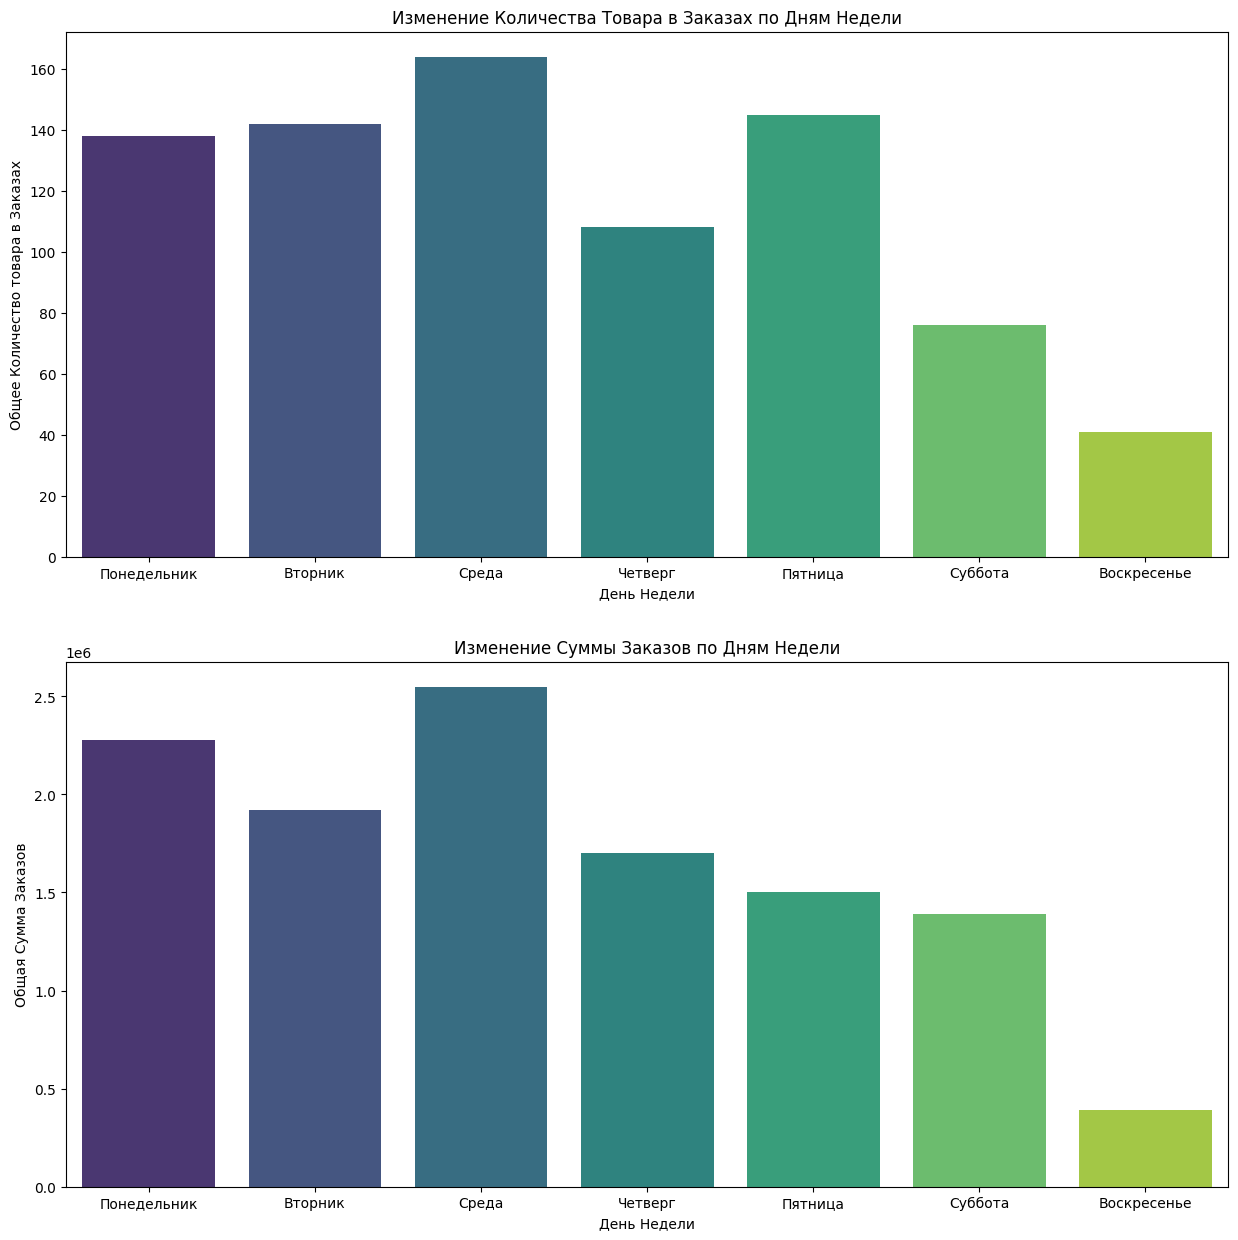

In [35]:
plot_sales_weekdays(gifts_purchases)

Анализ распределения суммы заказов по дням недели немного отличается:

 - Понедельник и среда являются лидером по количеству товаров в заказах.
 - Вторник и четверг демонстрируют схожие показатели.
 - Пятница и суббота демонстрируют схожие показатели. 
 - Воскресенье демонстрирует наименьшее количество товаров в заказах.

Эти данные могут подсказывать о паттернах в покупательском поведении, что может быть полезно для определения оптимальных дней для проведения маркетинговых акций.

**Рассчитаем сколько каждый клиент потратил в магазине**

,date,client_id,quantity_total,price_total
0,2022-10-26,1515915625857065470,5,174768.0
1,2022-10-28,1515915625842031428,3,4821.0
2,2022-11-02,1515915625805906601,1,5236.0
3,2022-11-02,1515915625835005143,4,70200.0
4,2022-11-03,1515915625835005077,8,29016.0


Рейтинг клиентов по общей сумме покупок:


client_id
1515915625803894158    957950.0
1515915625803892965    594503.0
1515915625858800593    371125.0
1515915625855755713    360460.0
1515915625824280360    311984.0
                         ...   
1515915625803209237      1453.0
1515915625928280841       749.0
1515915625964487373       669.0
1515915625803275365       669.0
1515915625835006190       669.0
Name: price_total, Length: 326, dtype: float64

Количество клиентов с покупками на 100000 и выше: 25
Количество клиентов с покупками на менее чем 100000: 301


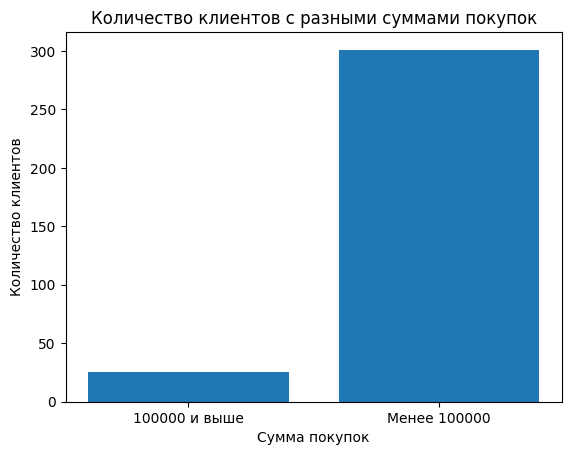

In [36]:
client_spending(gifts_purchases, 100000)

Из полученных данных можно сделать вывод, что большую часть дохода приносит небольшое количество клиентов. Например: свыше 100 тысяч за год потратили только 25 клиентов из 326. Этих клиентов можно выделить в VIP и предоставит им особую программу лояльности.

### Выводы

- В данных есть всплески с увеличением количества продаж. 
- Существует тенденция зависимости количества продаж от дня недели.
Эти данные могут подсказывать о паттернах в покупательском поведении, что может быть полезно для определения оптимальных дней для проведения маркетинговых акций. Например, пятница, с ее высоким показателем, может быть привлекательным днем для акций или специальных предложений, в то время как в понедельник можно сосредоточить усилия на стимулировании покупок.
- Важно отметить, что количество новых покупателей во всех магазинах гораздо больше, чем сделавших повторные покупки.
Это может указывать на необходимость проведение дополнительных мер по удержанию клиентов и повышению лояльности среди тех, кто уже совершил покупки. Работа с программами лояльности, персонализированными предложениями или скидками для постоянных клиентов может быть эффективным способом увеличить долю постоянных клиентов в общей клиентской базе. Также стоит дополнительно изучить причины, по которым новые клиенты не становятся постоянными, чтобы оптимизировать маркетинговые стратегии и улучшить клиентский опыт. 
Так исходя из этого модель буду строить используя времнной ряд.
- Также важным является тот факт, что большую часть прибыли для каждого магазина приносит ограниченное количество клиентов, которых можно выделить и  предоставить им особую программу лояльности.

## Подготовка данных.

Объединим данные в один датасет для дальнейшей работы.

In [37]:
# Объединим таблицы и добавим колонку категории магазина.

apparel_purchases['store_category_id'] = 1
marketplace_purchases['store_category_id'] = 2
gifts_purchases['store_category_id'] = 3

# Объединение таблиц
combined_data = pd.concat([apparel_purchases, marketplace_purchases, gifts_purchases], ignore_index=True).copy()

In [38]:
combined_data.head(5)

,client_id,quantity,price,date,message_id,recommended_by,month,day_of_week,store_category_id,created_at
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message,2023-09,4,1,NaT
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message,2023-09,4,1,NaT
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message,2023-09,4,1,NaT
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message,2023-09,4,1,NaT
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message,2023-09,4,1,NaT


In [39]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182097 entries, 0 to 182096
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   client_id          182097 non-null  int64         
 1   quantity           182097 non-null  int64         
 2   price              182097 non-null  float64       
 3   date               182097 non-null  datetime64[ns]
 4   message_id         182097 non-null  object        
 5   recommended_by     133915 non-null  object        
 6   month              182097 non-null  period[M]     
 7   day_of_week        182097 non-null  int32         
 8   store_category_id  182097 non-null  int64         
 9   created_at         48182 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int32(1), int64(3), object(2), period[M](1)
memory usage: 13.2+ MB


Удалим признаки "recommended_by" и "created_at" так как в них много пропусков.

In [40]:
combined_data = combined_data.drop(columns=['recommended_by','created_at'])

Обрежем в дате время

In [41]:
combined_data['date'] = pd.to_datetime(combined_data['date'], format='%Y.%M.%D')

In [42]:
combined_data.head()

,client_id,quantity,price,date,message_id,month,day_of_week,store_category_id
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,2023-09,4,1
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,2023-09,4,1
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,2023-09,4,1
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,2023-09,4,1
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,2023-09,4,1


Оценим количество дубликатов

In [43]:
print('Количество дубликатов в датасете:', combined_data.duplicated().count())

Количество дубликатов в датасете: 182097


Будем считать, что дубликаты это множественные заказы или различные товары в один день.
Агрегируем - объединим данные для дубликатов, суммируем количество и цену товаров.

In [44]:
data_grouped = combined_data.groupby(['client_id', 'date', 'store_category_id']).agg({'quantity': 'sum', 'price': 'sum', 'message_id': 'first'}).reset_index()
data_grouped.shape

(65576, 6)

In [45]:
data_grouped.head()

,client_id,date,store_category_id,quantity,price,message_id
0,1515915625440099873,2023-07-16 08:25:31,2,1,31998.0,1515915625440099873-1965-64abd07b9561d
1,1515915625440099873,2023-08-09 08:59:08,2,1,1218.0,1515915625440099873-2021-64d219c458813
2,1515915625440939402,2023-01-30 13:13:37,2,1,75998.0,1515915625440939402-1474-63d738fa8d5cc
3,1515915625440944408,2023-03-01 10:21:12,2,1,882.0,1515915625440944408-1587-63fef11f97d27
4,1515915625440944408,2023-05-02 08:49:57,2,1,6298.0,1515915625440944408-1752-6450b79616277


Рассмотрим данные в признаке 'message_id'

In [46]:
data_grouped['message_id'].value_counts().sum

<bound method Series.sum of message_id
1515915625489095763-6251-6311b13a4cf78     78
1515915625578358001-2065-64f04d148d718     57
1515915625448676587-1243-6365f1643ba84     39
1515915625446481060-2124-6513ae078fd95     38
1515915625546393273-1249-636b28f5752ca     37
                                           ..
1515915625517507916-2038-64dc5af35d40b      1
1515915625517516307-2034-64d9fe8774691      1
1515915625517705132-1575-63f99a0cebfd7      1
1515915625517521475-2023-64d36ab27beeb      1
1515915626011484905-16222-65291f460849e     1
Name: count, Length: 46668, dtype: int64>

Признак 'message_id'  имеет много уникальных значений с разной частотой в данных. Будем его использовать для построения модели. Это может помочь модели выявить скрытые паттерны и лучше предсказывать результаты. Закодируем 'message_id' в числовой формат

In [47]:
# Кодирование message_id в числовой формат
encoder = LabelEncoder()
data_grouped['message_id_encoded'] = encoder.fit_transform(data_grouped['message_id'])

# Удаление исходного столбца message_id
data_grouped.drop('message_id', axis=1, inplace=True)

In [48]:
# Сортировка данных по клиенту и дате
data_grouped = data_grouped.sort_values(['client_id', 'date'])

In [49]:
data_grouped.head()

,client_id,date,store_category_id,quantity,price,message_id_encoded
0,1515915625440099873,2023-07-16 08:25:31,2,1,31998.0,0
1,1515915625440099873,2023-08-09 08:59:08,2,1,1218.0,1
2,1515915625440939402,2023-01-30 13:13:37,2,1,75998.0,2
3,1515915625440944408,2023-03-01 10:21:12,2,1,882.0,3
4,1515915625440944408,2023-05-02 08:49:57,2,1,6298.0,4


Создадим временные признаки. Будем использовать RFM (Recency, Frequency, Monetary) с нарастающим итогом.
- recency — давность (как давно клиент что-то у  покупал);
- frequency — частота (как часто клиент покупает);
- monetary — деньги (общая сумма покупок клиента).

In [50]:
# Рассчитаем RFM кумулятивную сумму:
data_grouped['monetary'] = data_grouped.groupby('client_id')['price'].cumsum()
data_grouped['recency'] = data_grouped.groupby('client_id')['date'].diff().dt.days.fillna(999).astype(int)
data_grouped['frequency'] = data_grouped.groupby('client_id')['date'].cumcount() + 1

Если у клиента нет предыдущей даты покупки, то в этом случае используем заглушку со значением 999 - означает первая покупка.

In [51]:
data_grouped.head(10)

,client_id,date,store_category_id,quantity,price,message_id_encoded,monetary,recency,frequency
0,1515915625440099873,2023-07-16 08:25:31,2,1,31998.0,0,31998.0,999,1
1,1515915625440099873,2023-08-09 08:59:08,2,1,1218.0,1,33216.0,24,2
2,1515915625440939402,2023-01-30 13:13:37,2,1,75998.0,2,75998.0,999,1
3,1515915625440944408,2023-03-01 10:21:12,2,1,882.0,3,882.0,999,1
4,1515915625440944408,2023-05-02 08:49:57,2,1,6298.0,4,7180.0,61,2
5,1515915625440944408,2023-06-21 12:20:06,2,1,73998.0,5,81178.0,50,3
6,1515915625440947454,2022-11-06 17:14:50,2,2,202.0,6,202.0,999,1
7,1515915625440947454,2022-12-24 16:35:42,2,2,4284.0,7,4486.0,47,2
8,1515915625440952940,2022-11-11 05:17:51,2,1,479.0,8,479.0,999,1
9,1515915625440956290,2023-08-03 13:45:03,2,2,199998.0,10,199998.0,999,1


Рассчитаем разницу в датах для каждого клиента и получим количество дней до следующей покупки с помощью сдвига:

In [52]:
# data_grouped['days_to_next_purchase'] = data_grouped.groupby('client_id')['date'].diff().dt.days
data_grouped['days_to_next_purchase'] = -data_grouped.sort_values('date', ascending=False).groupby('client_id')['date'].diff().dt.days

In [53]:
data_grouped.head(5)

,client_id,date,store_category_id,quantity,price,message_id_encoded,monetary,recency,frequency,days_to_next_purchase
0,1515915625440099873,2023-07-16 08:25:31,2,1,31998.0,0,31998.0,999,1,25.0
1,1515915625440099873,2023-08-09 08:59:08,2,1,1218.0,1,33216.0,24,2,NaN
2,1515915625440939402,2023-01-30 13:13:37,2,1,75998.0,2,75998.0,999,1,NaN
3,1515915625440944408,2023-03-01 10:21:12,2,1,882.0,3,882.0,999,1,62.0
4,1515915625440944408,2023-05-02 08:49:57,2,1,6298.0,4,7180.0,61,2,51.0


Создадим целевую переменную, где 1 означает повторную покупку в течение 30 дней после заказа:

In [54]:
data_grouped['target'] = (data_grouped['days_to_next_purchase'] <= 30).astype(int)

In [55]:
data_grouped.head(10)

,client_id,date,store_category_id,quantity,price,message_id_encoded,monetary,recency,frequency,days_to_next_purchase,target
0,1515915625440099873,2023-07-16 08:25:31,2,1,31998.0,0,31998.0,999,1,25.0,1
1,1515915625440099873,2023-08-09 08:59:08,2,1,1218.0,1,33216.0,24,2,NaN,0
2,1515915625440939402,2023-01-30 13:13:37,2,1,75998.0,2,75998.0,999,1,NaN,0
3,1515915625440944408,2023-03-01 10:21:12,2,1,882.0,3,882.0,999,1,62.0,0
4,1515915625440944408,2023-05-02 08:49:57,2,1,6298.0,4,7180.0,61,2,51.0,0
5,1515915625440944408,2023-06-21 12:20:06,2,1,73998.0,5,81178.0,50,3,NaN,0
6,1515915625440947454,2022-11-06 17:14:50,2,2,202.0,6,202.0,999,1,48.0,0
7,1515915625440947454,2022-12-24 16:35:42,2,2,4284.0,7,4486.0,47,2,NaN,0
8,1515915625440952940,2022-11-11 05:17:51,2,1,479.0,8,479.0,999,1,NaN,0
9,1515915625440956290,2023-08-03 13:45:03,2,2,199998.0,10,199998.0,999,1,NaN,0


In [56]:
data_grouped = data_grouped.sort_values(['date'])

In [57]:
# Найдем дату, на которую нужно удалить последние 30 дней
date_to_exclude = data_grouped['date'].max() - pd.Timedelta(days=30)

# Удалим данные за последние 30 дней
data_grouped = data_grouped[data_grouped['date'] < date_to_exclude]

In [58]:
data_grouped['frequency'].value_counts()

frequency
1      44678
2       8305
3       3016
4       1461
5        858
       ...  
120        1
121        1
122        1
123        1
144        1
Name: count, Length: 144, dtype: int64

In [59]:
# Скопировать data_grouped в features_time_s
features_time_s = data_grouped.copy()

# Создание признаков "день месяца", "день недели", "неделя месяца" и "является ли день выходным"
features_time_s['total_price'] = features_time_s['price'] * features_time_s['quantity']
features_time_s['day_of_month'] = features_time_s['date'].dt.day
features_time_s['day_of_week'] = features_time_s['date'].dt.dayofweek
features_time_s['month'] = features_time_s['date'].dt.month
features_time_s['week_of_year'] = features_time_s['date'].dt.isocalendar().week
features_time_s['week_of_month'] = features_time_s['date'].apply(lambda x: (x.day - 1) // 7 + 1)
features_time_s['is_weekend'] = features_time_s['day_of_week'].isin([5, 6]).astype(int)
features_time_s['is_holiday'] = features_time_s['date'].isin(is_holiday_22_23).astype(int)

# Создаем список дат на следующие 30 дней от каждой даты в features_time_s
date_ranges = [pd.date_range(date, periods=30) for date in features_time_s['date']]
# Создаем новый признак 'holidays_next_30_days'
features_time_s['holidays_next_30_days'] = [sum(1 for holiday in is_holiday_22_23 if holiday in date_range) for date_range in date_ranges]


In [60]:
features_time_s = features_time_s.set_index('date')
# Удалить время из даты в индексе, оставить только дату
features_time_s.index = features_time_s.index.date

In [61]:
features_time_s.head(5)

,client_id,store_category_id,quantity,price,message_id_encoded,monetary,recency,frequency,days_to_next_purchase,target,total_price,day_of_month,day_of_week,month,week_of_year,week_of_month,is_weekend,is_holiday,holidays_next_30_days
2022-10-26,1515915625587818098,1,2,17998.0,9565,17998.0,999,1,NaN,0,35996.0,26,2,10,43,4,0,0,1
2022-10-26,1515915625588327029,1,1,2499.0,37935,2499.0,999,1,NaN,0,2499.0,26,2,10,43,4,0,0,1
2022-10-26,1515915625489888679,1,3,2213.0,9125,2213.0,999,1,NaN,0,6639.0,26,2,10,43,4,0,0,1
2022-10-26,1515915625857065470,3,5,174768.0,43257,174768.0,999,1,NaN,0,873840.0,26,2,10,43,4,0,0,1
2022-10-26,1515915625500418210,1,1,1859.0,13960,1859.0,999,1,NaN,0,1859.0,26,2,10,43,4,0,0,1


In [62]:
# Определяем целевой признак
X = features_time_s.drop(['client_id', 'days_to_next_purchase', 'total_price', 'target'], axis=1)
y = features_time_s['target']

In [63]:
display(features_time_s['target'].value_counts().to_frame().assign(percentage=lambda x: x/x.sum()).style.format({'percentage':'{:.2%}', 'target':'{:.0f}'}).set_caption('Распределение классов'))
print(y.shape)

,count,percentage
target,,
0,48579,79.01%
1,12908,20.99%


(61487,)


## Модель Catboost

In [64]:
# # Сетка параметров для подбора
# grid = {'learning_rate': [0.15],
#         'depth': [8,10],
#         'l2_leaf_reg': [1,2],}

# # Инициализация модели CatBoost с использованием GPU
# model = CatBoostClassifier(iterations=1000, task_type='GPU', devices='0:1', verbose=False) 

# # Подбор лучших параметров с помощью Grid Search
# grid_search_result = model.grid_search(grid, X=Pool(X_train, label=y_train), plot=True)

# # Получение лучших параметров
# best_params = grid_search_result['params']

# # Создание модели с лучшими параметрами и использованием GPU
# best_model = CatBoostClassifier(iterations=1000, task_type='GPU', devices='0:1', verbose=False, **best_params)

In [65]:
# model.plot_tree(tree_idx=0)

In [66]:
# for key,value in model.get_all_params().items():
#  print('{}, {}'.format(key,value))

In [68]:
# best_params

In [69]:
best_params = {'depth': 8,
 'od_wait': 50,
 'l2_leaf_reg': 1,
 'iterations': 1000,
 'learning_rate': 0.05}

In [70]:
best_model = CatBoostClassifier(verbose=False, **best_params, random_seed=42)

In [71]:
num_days = features_time_s.index.nunique()
print("Number of days in the dataset: ", num_days)

Number of days in the dataset:  336


In [72]:
# Создаем объект TimeSeriesSplit
n_splits = 11
tscv = TimeSeriesSplit(n_splits=n_splits)

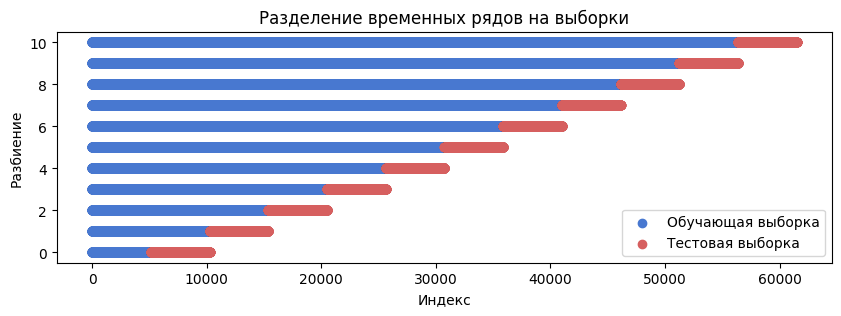

In [73]:
# Визуализируем разделение на выборки
plt.figure(figsize=(10, 3))
for i, (train_index, test_index) in enumerate(tscv.split(features_time_s)):
    plt.scatter(train_index, [i]*len(train_index), color='b', label='Обучающая выборка' if i==0 else "")
    plt.scatter(test_index, [i]*len(test_index), color='r', label='Тестовая выборка' if i==0 else "")

plt.xlabel('Индекс')
plt.ylabel('Разбиение')
plt.title('Разделение временных рядов на выборки')
plt.legend()
plt.show()

In [75]:
# Обучаем модель с использованием TimeSeriesSplit
for train_index, test_index in tqdm(tscv.split(X), total=tscv.get_n_splits()):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    start_time = time.time()  # Замеряем время начала обучения
    best_model.fit(X_train, y_train) 
    end_time = time.time()  # Замеряем время окончания обучения

    print('ROC_AUC:',roc_auc_score(y_train, best_model.predict(X_train)))
    # Выводим время обучения текущей итерации
    print(f"Время обучения: {end_time - start_time} секунд")

  9%|████                                        | 1/11 [00:02<00:27,  2.74s/it]

ROC_AUC: 0.9471820631232681
Время обучения: 2.7260711193084717 секунд


 18%|████████                                    | 2/11 [00:07<00:37,  4.11s/it]

ROC_AUC: 0.8745804515764442
Время обучения: 5.058910131454468 секунд


 27%|████████████                                | 3/11 [00:13<00:39,  4.88s/it]

ROC_AUC: 0.8280163038596129
Время обучения: 5.775953769683838 секунд


 36%|████████████████                            | 4/11 [00:19<00:37,  5.40s/it]

ROC_AUC: 0.8048229917299414
Время обучения: 6.163984775543213 секунд


 45%|████████████████████                        | 5/11 [00:26<00:34,  5.79s/it]

ROC_AUC: 0.7786974637925596
Время обучения: 6.464631080627441 секунд


 55%|████████████████████████                    | 6/11 [00:32<00:30,  6.02s/it]

ROC_AUC: 0.7625696002189823
Время обучения: 6.433655738830566 секунд


 64%|████████████████████████████                | 7/11 [00:39<00:25,  6.35s/it]

ROC_AUC: 0.7473472866475821
Время обучения: 6.982412815093994 секунд


 73%|████████████████████████████████            | 8/11 [00:47<00:20,  6.74s/it]

ROC_AUC: 0.7343671985378051
Время обучения: 7.544148921966553 секунд


 82%|████████████████████████████████████        | 9/11 [00:55<00:14,  7.21s/it]

ROC_AUC: 0.721941831312199
Время обучения: 8.201626062393188 секунд


 91%|███████████████████████████████████████    | 10/11 [01:04<00:07,  7.76s/it]

ROC_AUC: 0.716838240332417
Время обучения: 8.927515029907227 секунд


100%|███████████████████████████████████████████| 11/11 [01:15<00:00,  6.82s/it]

ROC_AUC: 0.7116976037067535
Время обучения: 10.358633995056152 секунд


In [76]:
# from sklearn.metrics import precision_recall_curve

# precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plt.figure(figsize=(6, 6))
# plt.plot(thresholds, precision[:-1])
# plt.xlabel('thresholds')
# plt.ylabel('Precision-Recall')
# plt.plot(thresholds, recall[:-1])
# plt.grid()
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.show()

# print(f'Best threshold = {np.round(thresholds[np.argmin(np.abs(precision - recall))], 3)}')

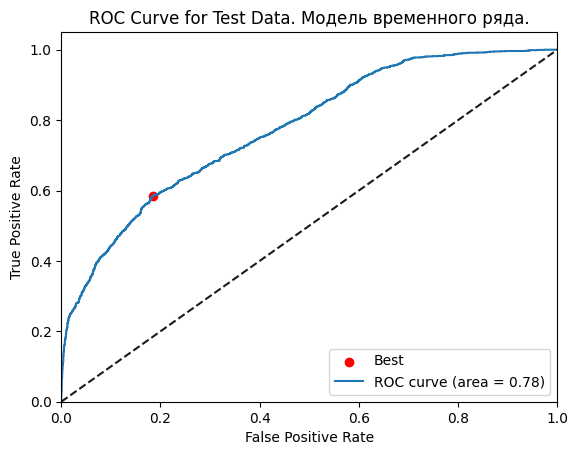

Лучшие пороговое значение 0.284
ROC AUC на тестовой выборке: 0.7758074349504938


,0,1,accuracy,macro avg,weighted avg
precision,0.81,0.60,0.74,0.7,0.74
recall,0.81,0.58,0.74,0.7,0.74
f1-score,0.81,0.59,0.74,0.7,0.74
support,3487.00,1636.00,0.74,5123.0,5123.00


In [77]:
y_pred = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)

# Построение ROC-AUC кривой для тестового набора данных
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
idx = np.argmax(tpr - fpr)
best_thresh = thresholds[idx]
plt.figure()
plt.scatter(fpr[idx], tpr[idx], marker="o", color="red", label="Best")
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data. Модель временного ряда.')
plt.legend(loc="lower right")
plt.show()

# Предсказываем на тестовой выборке и вычисляем ROC AUC
y_pred_class = best_model.predict(X_test)
roc_auc_test = roc_auc_score(y_test, y_pred)
print('Лучшие пороговое значение', best_thresh.round(3))
print(f'ROC AUC на тестовой выборке: {roc_auc_test}')

report = classification_report(y_test, y_pred > best_thresh, output_dict=True)
df_report = pd.DataFrame(report).round(2)
df_report

###### Метрика precision класса 1 равная 0.6 указывает на то, что из всех предсказанных как класс 1 (покупатель совершит повторную покупку), только 60% действительно являются классом 1.
Метрика recall класса 1 равный 0.58, означает, что модель верно классифицирует 58% всех истинных случаев принадлежности к классу 1 среди всех случаев, которые действительно принадлежат к классу 1.

Стоит учесть, что когда модель предсказывает с высокой уверенностью, что определенные клиенты совершат повторные покупки (класс 1) и при этом она довольно точна в своих прогнозах, то в данном случае стимулирование этих клиентов может быть не столь эффективным, так как они, скорее всего, все равно сделают покупку.

В этом случае стоит рассмотреть некоторые альтернативные стратегии, например:

Сосредоточиться на привлечении и удержании клиентов, для которых модель предсказывает менее высокую вероятность повторной покупки (класс 0).
Использовать информацию о вероятности повторной покупки как фактор в динамической адаптации стратегий взаимодействия с клиентами.
Разработать программы лояльности или персонализированные предложения, которые будут нацелены на клиентов с низкой вероятностью повторной покупки.
Важно сбалансировать стратегии стимулирования клиентов и учитывать не только вероятности, предсказанные моделью, но и другие факторы, такие как ценность клиента, его потенциальность для лояльности и другие цели бизнеса.

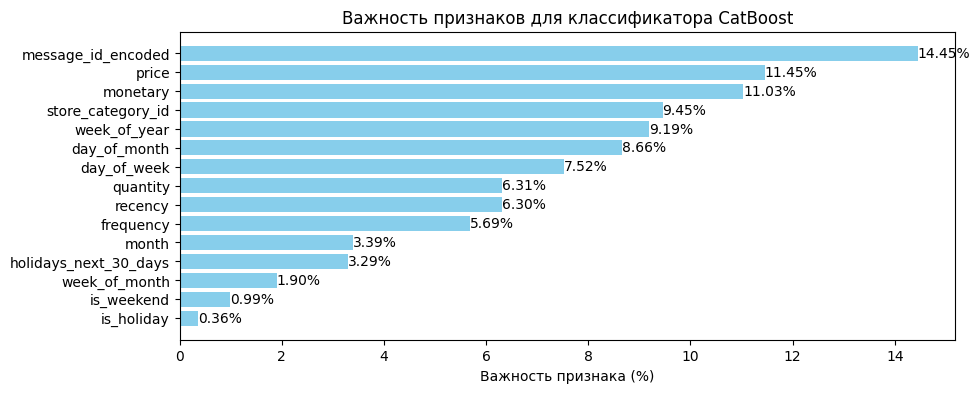

In [78]:
# Важность признаков
feature_importance = best_model.feature_importances_

# Имена признаков, использованные при обучении модели
feature_names = X.columns

# Сортировка индексов признаков по важности в убывающем порядке
sorted_idx = np.argsort(feature_importance)[::-1]

# Вычисление процентного вклада каждого признака в общую важность
percent_importance = (feature_importance[sorted_idx] / np.sum(feature_importance)) * 100

# Создание горизонтальной столбчатой диаграммы
fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.barh(range(len(sorted_idx)), percent_importance, align='center', color='skyblue')
ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_xlabel('Важность признака (%)')
ax.set_title('Важность признаков для классификатора CatBoost')

# Добавление текста с процентами на столбцы
for i, bar in enumerate(bars):
    percentage = f'{percent_importance[i]:.2f}%'
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, percentage, 
            va='center', ha='left', fontsize=10, color='black')

plt.gca().invert_yaxis() 
plt.show()

Похоже, признак message_id_encoded имеет высокий вес (14.45), что указывает на его значимость для модели. Этот признак может оказать значительное влияние на предсказания.
Остальные признаки также важны, особенно price, monetary, store_category_id и другие, каждый вносит свой вклад в прогнозирование целевой переменной.

## Вывод:

В этом случае стоит рассмотреть некоторые альтернативные стратегии, например:

Сосредоточиться на привлечении и удержании клиентов, для которых модель предсказывает менее высокую вероятность повторной покупки (класс 0).
Разработать программы лояльности или персонализированные предложения, которые будут нацелены на клиентов с низкой вероятностью повторной покупки.
Важно сбалансировать стратегии стимулирования клиентов и учитывать не только вероятности, предсказанные моделью, но и другие факторы, такие как ценность клиента.